In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
%matplotlib inline

In [3]:
ruta = "Fifa_stats.csv"
df = pd.read_csv(ruta)
df.head()

,sofifa_id,long_name,dob,age,nationality,club,preferred_foot,height_cm,weight_kg,overall,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,Lionel Andrés Messi Cuccittini,1987-06-24,32,Argentina,FC Barcelona,Left,170,72,94,...,75,96,33,37,26,6,11,15,14,8
1,20801,Cristiano Ronaldo dos Santos Aveiro,1985-02-05,34,Portugal,Juventus,Right,187,83,93,...,85,95,28,32,24,7,11,15,14,11
2,190871,Neymar da Silva Santos Junior,1992-02-05,27,Brazil,Paris Saint-Germain,Right,175,68,92,...,90,94,27,26,29,9,9,15,15,11
3,200389,Jan Oblak,1993-01-07,26,Slovenia,Atlético Madrid,Right,188,87,91,...,11,68,27,12,18,87,92,78,90,89
4,183277,Eden Hazard,1991-01-07,28,Belgium,Real Madrid,Right,175,74,91,...,88,91,34,27,22,11,12,6,8,8


En la practica solo se considerara los futbolistas que no son guardametas

In [5]:
varg = [x for x in df.columns if x[:2] == 'gk']
varg

['gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_reflexes',
 'gk_speed',
 'gk_positioning']

In [7]:
df.drop(columns=varg,inplace=True)

In [8]:
df = df.dropna()

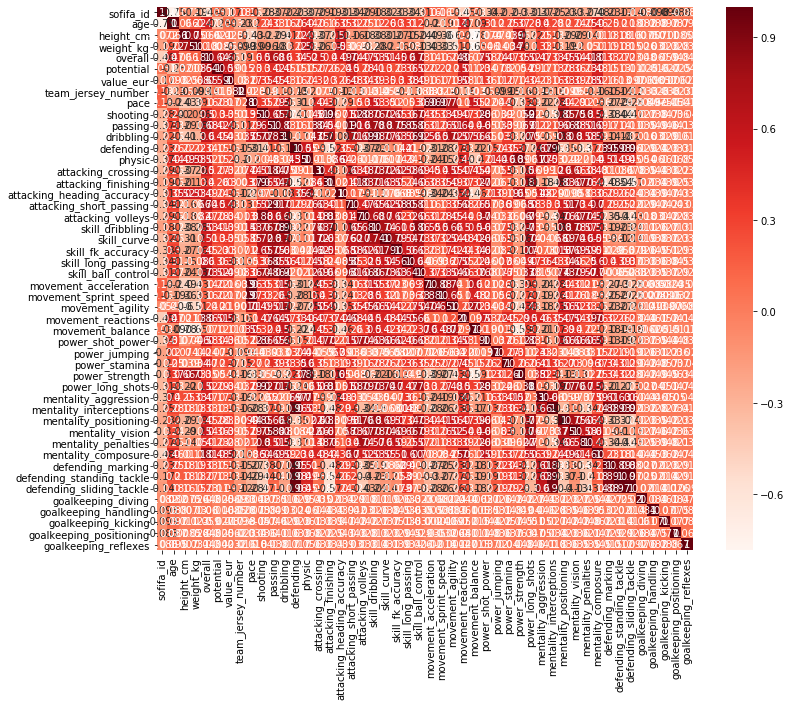

In [9]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
cor_target = abs(cor['overall'])
relevant_features = cor_target[cor_target > 0.6]
relevant_features

overall                    1.000000
potential                  0.635030
value_eur                  0.653015
passing                    0.684827
dribbling                  0.602770
attacking_short_passing    0.744176
skill_ball_control         0.732825
movement_reactions         0.864817
mentality_composure        0.811634
Name: overall, dtype: float64

In [13]:
df[['potential','value_eur','passing','dribbling','attacking_short_passing',
    'skill_ball_control','movement_reactions','mentality_composure']].corr()

,potential,value_eur,passing,dribbling,attacking_short_passing,skill_ball_control,movement_reactions,mentality_composure
potential,1.000000,0.585516,0.424725,0.451538,0.497921,0.517379,0.509668,0.481519
value_eur,0.585516,1.000000,0.452677,0.431344,0.484203,0.493312,0.579388,0.523867
passing,0.424725,0.452677,1.000000,0.830219,0.909783,0.855674,0.644398,0.686796
dribbling,0.451538,0.431344,0.830219,1.000000,0.710520,0.921431,0.565799,0.591241
attacking_short_passing,0.497921,0.484203,0.909783,0.710520,1.000000,0.811429,0.684017,0.696174
skill_ball_control,0.517379,0.493312,0.855674,0.921431,0.811429,1.000000,0.664462,0.698519
movement_reactions,0.509668,0.579388,0.644398,0.565799,0.684017,0.664462,1.000000,0.757309
mentality_composure,0.481519,0.523867,0.686796,0.591241,0.696174,0.698519,0.757309,1.000000


con el umbral igual a 6 obtenemos que las variables mas correlacionadas con la target son:
'potential','value_eur','passing','dribbling','gk_kicking','gk_reflexes',
'gk_positioning','movement_reactions','mentality_composure'
pero algunas estan correlacionadas por lo cual queda:
'gk_kicking','potential',passing

In [19]:
varaux = list(df.describe().columns)
varaux = [x for x in varaux if x[:2] != 'gk']

48

In [15]:
var = [x for x in varaux if x != 'overall']

In [17]:
X = df[var]
y = df['overall']

In [18]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

/home/diegoias/Documents/CieciaDatos/cdd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['sofifa_id', 'age', 'weight_kg', 'potential', 'value_eur', 'team_jersey_number', 'passing', 'dribbling', 'defending', 'physic', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'skill_curve', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_reflexes']


In [20]:
#numero de caracteristicas
nof_list = np.arange(1,48)
high_score = 0

#proceso para almacenar las caracteristicas óptimas
nof = 0
score_list =[]

for n in range(len(nof_list)):
    print(n)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score =model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
print("Numero optimo de caracteristicas: %d"%nof)
print("Desempeño con %d caracteristicas: %f"%(nof,high_score))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
Numero optimo de caracteristicas: 47
Desempeño con 47 caracteristicas: 0.936869


In [21]:
cols = list(X.columns)
model = LinearRegression()
rfe = RFE(model,47)
X_rfe = rfe.fit_transform(X,y)

model.fit(X_rfe,y)
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sofifa_id', 'age', 'height_cm', 'weight_kg', 'potential', 'value_eur',
       'team_jersey_number', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positi

In [13]:
reg = LassoCV()
reg.fit(X,y)
coef = pd.Series(reg.coef_, index = X.columns)

print("Número optiimo de caracteristicas:" + str(sum(coef != 0)))
print("Desempeño mediante la regularizacion Lasso: %f"%reg.score(X,y))

/home/diegoias/Documents/CieciaDatos/cdd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Número optiimo de caracteristicas:1
Desempeño mediante la regularizacion Lasso: 0.425509


Text(0.5, 1.0, 'Importancia de las caracteristicas usado el modelo Lasso')

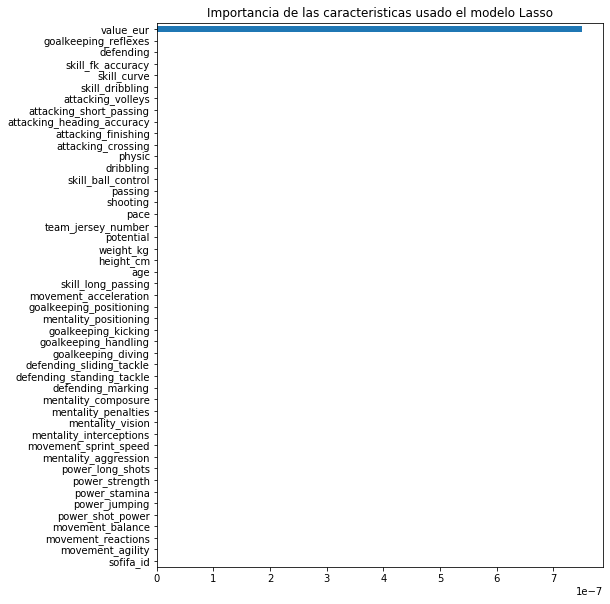

In [14]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)

imp_coef.plot(kind = 'barh')
plt.title("Importancia de las caracteristicas usado el modelo Lasso")